# CSC 730 Assignment 6 - Measuring Performance – ROC and PR Curves 
## Mangesh Sakordekar

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.utils import shuffle
import xgboost as xgb
from sklearn.metrics import confusion_matrix

### Reading the Data

In [2]:
(X_train, _), (X_test, _) = mnist.load_data()
impulse_noise_imgs = np.load('../Datasets/mnist_c/impulse_noise/train_images.npy').reshape((60000,28*28))
stripe_imgs = np.load('../Datasets/mnist_c/stripe/train_images.npy').reshape((60000,28*28))
spatter_imgs = np.load('../Datasets/mnist_c/spatter/train_images.npy').reshape((60000,28*28))

Text(0.5, 1.0, 'Spatter')

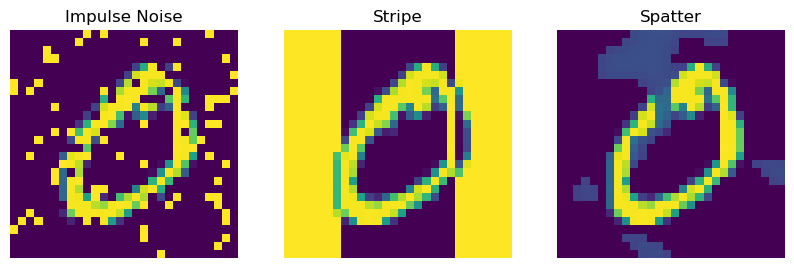

In [3]:
fig = plt.figure(figsize=(10, 4)) 

fig.add_subplot(1, 3, 1) 
plt.imshow(impulse_noise_imgs[1].reshape((28,28))) 
plt.axis('off') 
plt.title("Impulse Noise") 

fig.add_subplot(1, 3, 2) 
plt.imshow(stripe_imgs[1].reshape((28,28))) 
plt.axis('off') 
plt.title("Stripe") 

fig.add_subplot(1, 3, 3) 
plt.imshow(spatter_imgs[1].reshape((28,28))) 
plt.axis('off') 
plt.title("Spatter") 

### Making Train and Test Datasets

In [4]:
X_train = np.concatenate((X_train.reshape((60000, 28*28)), 
                          impulse_noise_imgs[:600,:], stripe_imgs[:600,:], 
                          spatter_imgs[:600,:]), axis=0)
X_test = np.concatenate((X_test.reshape((10000, 28*28)), 
                         impulse_noise_imgs[600:700,:], stripe_imgs[600:700,:], 
                         spatter_imgs[600:700,:]), axis=0)

In [5]:
y_train = np.concatenate((np.zeros((60000)), np.ones((1800))))
y_test = np.concatenate((np.zeros((10000)), np.ones((300))))

### Function Definitions

In [6]:
def get_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tpr = cm[0,0] / (cm[0,0] + cm[0,1])
    fpr = cm[1,0] / (cm[1,0] + cm[1,1])
    precision = cm[0,0] / (cm[0,0] + cm[1,0])
    return np.array([[tpr, fpr, precision]])

In [7]:
def iterate_range( start, end, step , y_true, y_probs):
    itr = start
    metrics = np.array([[0,0,1]])
    
    while itr <= end:
        y_preds = y_probs > itr
        metrics = np.append( metrics, get_metrics(y_true, y_preds), axis=0)
        itr += step

    metrics = np.append( metrics, np.array([[1,1,0]]), axis=0)
    return metrics

In [8]:
def fit_model(X_train, y_train, X_test, y_test):
    mixed_X_train, mixed_y_train = shuffle(X_train, y_train, random_state=42)
    mixed_X_test, mixed_y_test = shuffle(X_test, y_test, random_state=42)

    detector = xgb.XGBClassifier()
    detector.fit(mixed_X_train, mixed_y_train)

    anomaly_scores = detector.predict_proba(mixed_X_test)[:,1]

    return anomaly_scores, mixed_y_test
    
    

### Measuring Performance

In [9]:
scores, y_true = fit_model(X_train, y_train, X_test, y_test)
metrics = iterate_range(0.01, 1.0, 0.01, y_true, scores)

### ROC Curve

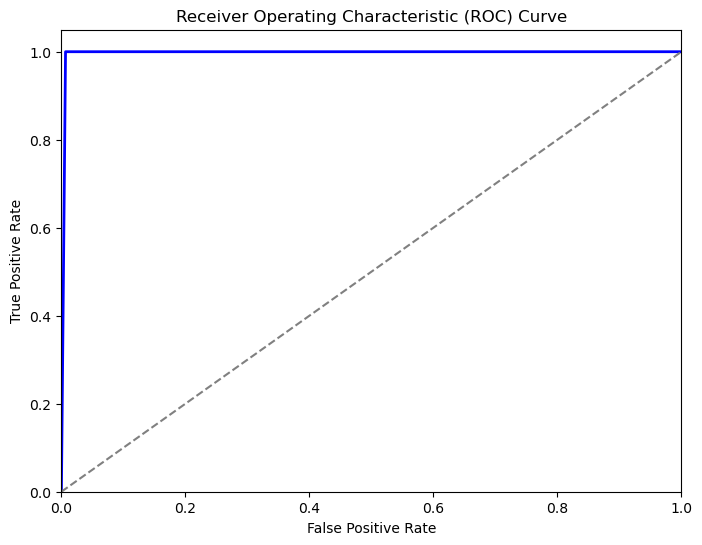

In [10]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(metrics[:,1], metrics[:,0], color='blue', lw=2, label='ROC curve' )
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()
    

### Precision Recall Curve

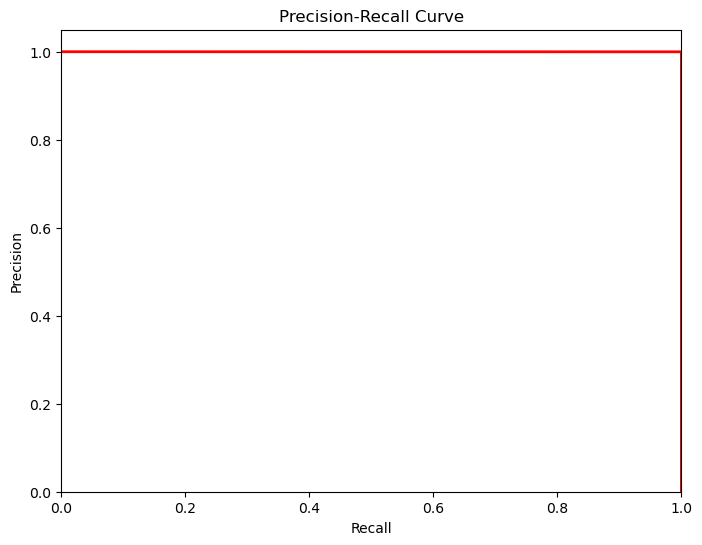

In [11]:
# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(metrics[:,0], metrics[:,2], color='red', lw=2, label='Precision-Recall curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()